### Experimenting with data and Unsupervised Learning

Labels come from 2 different PSG systems: Remlogic and Somnomedics. EMFIT is the piezoelectric mat and Somnofy is the radar. Sleep stage labels are as follows:

0 = Awake \
1 = REM \
2 = Light  \
3 = Deep 


In [41]:
#!pip3 install tsfresh

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features

from loader import *
from helpers import *
import pandas as pd
import numpy as np 

In [3]:
x, y, x_big, y_big = get_nn_patients()
x.shape, y.shape, x_big.shape, y_big.shape

((50, 857, 2), (50, 857), (0,), (0,))

In [2]:
def get_df(plist):
    data = []
    for subjectId in plist:
        sleep_stages = read_patient_data(subjectId)
        augmented = augment_data(sleep_stages)
        augmented = augmented.reset_index()
        augmented.drop('index', axis=1, inplace=True)
        augmented = augmented.reset_index()
        augmented = augmented.rename(columns={'index': 'timestamp'})
        for row in range(augmented.shape[0]):
            data.append([row, augmented["sleep_stage_num_somnofy"][row],
                        augmented["sleep_stage_num_emfit"][row],
                        augmented["sleep_stage_num_psg"][row]])
    df = pd.DataFrame(data, columns=["id", 'radar', 'mat', "psg"])
    return df

In [3]:
excluded, included = PARTICIPANT_IDS[:15], PARTICIPANT_IDS[15:]
df = get_df(included)

In [4]:
df

,id,radar,mat,psg
0,0,2.0,2.0,2.0
1,1,2.0,2.0,2.0
2,2,2.0,2.0,2.0
3,3,2.0,2.0,2.0
4,4,2.0,2.0,2.0
...,...,...,...,...
30847,852,2.0,2.0,2.0
30848,853,2.0,2.0,2.0
30849,854,2.0,2.0,0.0
30850,855,2.0,2.0,2.0


### no grouping (DOESNT WORK w/ feature extraction)

In [5]:
""" 90% of magic lies
x = df[["radar", "mat"]].reset_index()
features = x.rename(columns={'index': 'id'})
y = df["psg"] 
"""
features = df[[ "radar", "mat"]]
y = df["psg"]

In [6]:
features.shape , y.shape

((30852, 2), (30852,))

### group by each timestamp mixing patient

In [79]:
df = df.sort_values('id')
y = []
for i in range(MEAN_SIZE):
    y.append(int(df[df["id"]==i]["psg"].mean()))
x = df[["id", "radar", "mat"]]
y = pd.Series(y)

In [80]:
x

,id,radar,mat
0,0,0.0,0.0
32566,0,3.0,1.0
29995,0,2.0,2.0
8570,0,2.0,2.0
30852,0,0.0,0.0
...,...,...,...
24852,856,0.0,0.0
33422,856,1.0,2.0
5141,856,0.0,0.0
28280,856,1.0,1.0


### group by a group of timestamp 
in groups of 9 sample ~4.5 min

In [7]:
n_sample = 9
x = df
for i in range(0, x.shape[0], n_sample):
    avg = round(x["psg"].iloc[i:i+n_sample].mean())
    x.loc[i:i+n_sample, "psg"] = avg
    x.loc[i:i+n_sample, "id"] = i / n_sample

In [8]:
y = x[["id", "psg"]]
y.drop_duplicates(inplace=True)
y = y.reset_index()
y = y["psg"]
x = x[["id", "radar", "mat"]]
x.shape, y.shape

/var/folders/7r/61bttw_50_7_mhx02bntv9qm0000gn/T/ipykernel_17567/1295387275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop_duplicates(inplace=True)


((38565, 3), (4285,))

## Feature Extraction and Decision Tree

In [9]:
features = extract_features(x, column_id="id")

Feature Extraction: 100%|███████████████████████| 30/30 [00:46<00:00,  1.55s/it]


In [10]:
features

,radar__variance_larger_than_standard_deviation,radar__has_duplicate_max,radar__has_duplicate_min,radar__has_duplicate,radar__sum_values,radar__abs_energy,radar__mean_abs_change,radar__mean_change,radar__mean_second_derivative_central,radar__median,...,mat__permutation_entropy__dimension_6__tau_1,mat__permutation_entropy__dimension_7__tau_1,mat__query_similarity_count__query_None__threshold_0.0,"mat__matrix_profile__feature_""min""__threshold_0.98","mat__matrix_profile__feature_""max""__threshold_0.98","mat__matrix_profile__feature_""mean""__threshold_0.98","mat__matrix_profile__feature_""median""__threshold_0.98","mat__matrix_profile__feature_""25""__threshold_0.98","mat__matrix_profile__feature_""75""__threshold_0.98",mat__mean_n_absolute_max__number_of_maxima_7
0,0.0,1.0,1.0,1.0,0.0,0.0,0.000,0.000,0.000000,0.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0.0,1.0,1.0,1.0,7.0,7.0,0.125,0.125,0.000000,1.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2,0.0,1.0,1.0,1.0,9.0,9.0,0.000,0.000,0.000000,1.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
3,0.0,1.0,1.0,1.0,13.0,21.0,0.125,0.125,0.000000,1.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.571429
4,0.0,1.0,1.0,1.0,18.0,36.0,0.000,0.000,0.000000,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,0.0,1.0,0.0,1.0,16.0,32.0,0.250,0.250,-0.142857,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4281,0.0,1.0,1.0,1.0,18.0,36.0,0.000,0.000,0.000000,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4282,0.0,1.0,1.0,1.0,18.0,36.0,0.000,0.000,0.000000,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4283,0.0,1.0,1.0,1.0,18.0,36.0,0.000,0.000,0.000000,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.714286


In [11]:
impute(features)

filtered_features = select_features(features, y)
filtered_features

/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['radar__autocorrelation__lag_9' 'radar__partial_autocorrelation__lag_4'
 'radar__partial_autocorrelation__lag_5'
 'radar__partial_autocorrelation__lag_6'
 'radar__partial_autocorrelation__lag_7'
 'radar__partial_autocorrelation__lag_8'
 'radar__partial_autocorrelation__lag_9'
 'radar__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)'
 'r

,radar__sum_values,"radar__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)",...,"radar__fft_coefficient__attr_""abs""__coeff_1",radar__count_below_mean,"radar__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6","radar__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","radar__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6","radar__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",radar__longest_strike_below_mean,"radar__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","radar__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8",radar__mean_second_derivative_central
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,7.0,1.782079,2.028146,1.141360,1.523991,1.727377,0.948147,1.253816,1.362386,0.754207,...,1.879385,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.000000
2,9.0,2.233360,2.336893,1.519858,2.020684,2.235496,1.332403,1.782079,2.028146,1.141360,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,13.0,3.212904,3.311400,2.080852,2.730053,2.845012,1.702354,2.233360,2.336893,1.323856,...,2.879385,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.000000
4,18.0,4.466720,4.673786,3.039716,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,16.0,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,3.047983,3.454755,1.896293,...,2.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.142857
4281,18.0,4.466720,4.673786,3.039716,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4282,18.0,4.466720,4.673786,3.039716,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4283,18.0,4.466720,4.673786,3.039716,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [7]:
# train and test split
X_feature_train, X_feature_test, y_train, y_test = train_test_split(features, y, test_size=.33)
#X_filtered_train, X_filtered_test = X_feature_train[filtered_features.columns], X_feature_test[filtered_features.columns]


In [8]:
X_feature_train.shape, X_feature_test.shape, y_train.shape, y_test.shape

((20670, 2), (10182, 2), (20670,), (10182,))

In [11]:
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(X_feature_train, y_train) # CHANGE
preds = classifier_feature.predict(X_feature_train)

In [12]:
print(classification_report(y_test,preds))
print(balanced_accuracy_score(y_test,preds))
print(accuracy_score(y_test,preds))

ValueError: Found input variables with inconsistent numbers of samples: [10182, 20670]

In [13]:
df_te = get_df(excluded)
x_te = df_te[["radar", "mat"]].reset_index()
x_te = x_te.rename(columns={'index': 'id'})
y_te = df_te["psg"]
x_te.shape, y_te.shape

((12855, 3), (12855,))

In [14]:
df_te = get_df(excluded)
df_te = df_te.sort_values('id')
y_te = []
for i in range(MEAN_SIZE):
    y_te.append(round(df_te[df_te["id"]==i]["psg"].mean()))
x_te = df_te[["id", "radar", "mat"]]
y_te = pd.Series(y_te)
y_te = df_te["psg"]

In [15]:
features = extract_features(x_te, column_id="id")
impute(features)
x_te_filtered = features[filtered_features.columns]


Feature Extraction: 100%|███████████████████████| 30/30 [00:13<00:00,  2.23it/s]
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['radar__partial_autocorrelation__lag_7'
 'radar__partial_autocorrelation__lag_8'
 'radar__partial_autocorrelation__lag_9'
 'radar__spkt_welch_density__coeff_8'
 'radar__ar_coefficient__coeff_0__k_10'
 'radar__ar_coefficient__coeff_1__k_10'
 'radar__ar_coefficient__coeff_2__k_10'
 'radar__ar_coefficient__coeff_3__k_10'
 'radar__ar_coefficient__coeff_4__k_10'
 'radar__ar_coefficient__coeff_5__k_10'
 'radar__ar_coefficient__coeff_6__k_10'
 'radar__ar_coefficient__coeff_7__k_10'
 'radar__ar_coefficient__coeff_8__k_10'
 'radar__ar_coefficient__coeff_9__k_10'
 'radar__fft_coefficient__attr_"real"__coeff_8'
 'radar__fft_coefficient__attr_"real"__coeff_9'
 'radar__fft_coefficient__attr_"real"__coeff_10'
 'radar__fft_coefficient__attr_"real"__coeff_11'
 'radar__fft_coefficient__attr

NameError: name 'filtered_features' is not defined

In [16]:
df_te = get_df(excluded)
x_te = df_te[["radar", "mat"]]
y_te = df_te["psg"]

In [17]:
preds = classifier_feature.predict(x_te)
print(classification_report(y_te,preds))
print(balanced_accuracy_score(y_te,preds))
print(accuracy_score(y_te,preds))

              precision    recall  f1-score   support

         0.0       0.72      0.51      0.59      2175
         1.0       0.53      0.67      0.59      2310
         2.0       0.69      0.72      0.71      6219
         3.0       0.67      0.60      0.63      2151

    accuracy                           0.65     12855
   macro avg       0.65      0.62      0.63     12855
weighted avg       0.66      0.65      0.65     12855

0.6242268142293063
0.6549980552314275


<AxesSubplot:>

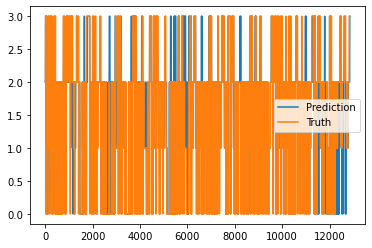

In [18]:
output = pd.DataFrame(preds, columns = ['Prediction'])
output["Truth"] = y_te
output.plot()

[Text(0.5, 0.9, 'X[0] <= 1.5\ngini = 0.682\nsamples = 20670\nvalue = [5146, 3010, 9575, 2939]'),
 Text(0.25, 0.7, 'X[0] <= 0.5\ngini = 0.677\nsamples = 8629\nvalue = [3524, 2479, 2325, 301]'),
 Text(0.125, 0.5, 'X[1] <= 1.5\ngini = 0.54\nsamples = 4836\nvalue = [3028, 444, 1158, 206]'),
 Text(0.0625, 0.3, 'X[1] <= 0.5\ngini = 0.42\nsamples = 2514\nvalue = [1860, 331, 309, 14]'),
 Text(0.03125, 0.1, 'gini = 0.251\nsamples = 1211\nvalue = [1042, 90, 70, 9]'),
 Text(0.09375, 0.1, 'gini = 0.538\nsamples = 1303\nvalue = [818, 241, 239, 5]'),
 Text(0.1875, 0.3, 'X[1] <= 2.5\ngini = 0.604\nsamples = 2322\nvalue = [1168, 113, 849, 192]'),
 Text(0.15625, 0.1, 'gini = 0.592\nsamples = 1884\nvalue = [981, 108, 680, 115]'),
 Text(0.21875, 0.1, 'gini = 0.638\nsamples = 438\nvalue = [187, 5, 169, 77]'),
 Text(0.375, 0.5, 'X[1] <= 1.5\ngini = 0.6\nsamples = 3793\nvalue = [496, 2035, 1167, 95]'),
 Text(0.3125, 0.3, 'X[1] <= 0.5\ngini = 0.511\nsamples = 1640\nvalue = [278, 1076, 282, 4]'),
 Text(0.2812

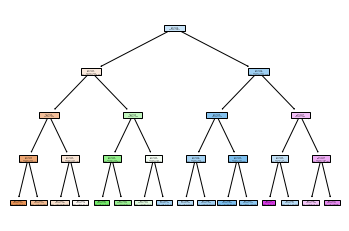

In [19]:
from sklearn import tree
tree.plot_tree(classifier_feature, filled=True)


### Decision Tree

In [20]:
x, y, x_big, y_big = get_nn_patients(raw=True)
x.shape, y.shape, x_big.shape, y_big.shape

((51, 857, 9), (51, 857), (0,), (0,))

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=42)
train, test = x_train.shape[0] * x_train.shape[1], x_test.shape[0] * x_test.shape[1]
x_train = x_train.reshape(train, x_train.shape[2])
x_test = x_test.reshape(test, x_test.shape[2])
y_train = y_train.reshape(train)
y_test = y_test.reshape(test)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((29995, 9), (13712, 9), (29995,), (13712,))

In [37]:
# Selecting the Best important features according to Logistic Regression
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select=3, step = 1)
rfe_selector.fit(x_train, y_train)
print(rfe_selector.get_support())
# top 5: [0,2,4,5,8]
# top 3: [0,2,5]

/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[ True False  True False False  True False False False]


In [38]:
x_featured, x_test = x_train[:,[0,2,5]], x_test[:,[0,2,5]]
x_featured.shape

(29995, 5)

In [39]:
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(x_featured, y_train) 
preds = classifier_feature.predict(x_test)

In [40]:
print(classification_report(y_test,preds))
print(balanced_accuracy_score(y_test,preds))
print(accuracy_score(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.50      0.47      0.49      3679
         1.0       0.38      0.43      0.41      1920
         2.0       0.57      0.54      0.56      6382
         3.0       0.40      0.45      0.42      1731

    accuracy                           0.50     13712
   macro avg       0.46      0.48      0.47     13712
weighted avg       0.50      0.50      0.50     13712

0.4753964971743162
0.4978850641773629


### KMeans

In [26]:
x, y, x_big, y_big = get_nn_patients(raw=True)
x.shape, y.shape, x_big.shape, y_big.shape
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33)
train, test = x_train.shape[0] * x_train.shape[1], x_test.shape[0] * x_test.shape[1]
x_train = x_train.reshape(train, x_train.shape[2])
x_test = x_test.reshape(test, x_test.shape[2])
y_train = y_train.reshape(train)
y_test = y_test.reshape(test)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
x_train, x_test = x_train[:,[0,2,5]], x_test[:,[0,2,5]]

In [27]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(x_train)

In [28]:
np.unique(y_km)

array([0, 1, 2, 3], dtype=int32)

In [29]:
print(classification_report(y_train,y_km))
print(balanced_accuracy_score(y_train,y_km))
print(accuracy_score(y_train,y_km))

              precision    recall  f1-score   support

         0.0       0.28      0.26      0.27      6179
         1.0       0.03      0.08      0.05      4595
         2.0       0.13      0.06      0.08     13832
         3.0       0.15      0.21      0.18      4532

    accuracy                           0.13     29138
   macro avg       0.15      0.15      0.14     29138
weighted avg       0.15      0.13      0.13     29138

0.15019674270235744
0.12578076738279909
